# Averaging on Stiefel manifold

**Riemannian exponential and logarithmic maps**  
Compute Riemannian mean on St(p, n) by applying exponential map to the arithmetic average of logarithm-mapped points from a manifold to a tangent space.

Based on:  

_A Matrix-Algebraic Algorithm for the Riemannian Logarithm  
on the Stiefel Manifold under the Canonical Metric_  
Zimmermann, Ralf  
SIAM J. Matrix Anal. & Appl., 38(2), 322–342.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from numpy.linalg import qr
from scipy.linalg import expm, logm

import random

## Create data

Create an element of St(2, 3), 2-dimensional orthonormal frame in $\mathbb{R}^3$

In [2]:
Frame = np.array([[1, 0, 0], [0, 1, 0]]).T
Frame.shape

(3, 2)

Create $N$ elements of SO(3), special orhogonal group of rotation matrices, to rotate St(2, 3) along Z-axis by $N$ degrees by each rotation matrix

In [3]:
N = 61
SO = np.zeros((N, 3, 3))

for i, phi in enumerate(range(0, N)):
    phi = (phi + 1) / 360 * 2 * np.pi
    SO[i] = np.array([
        [np.cos(phi), -np.sin(phi), 0],
        [np.sin(phi), np.cos(phi), 0],
        [0, 0, 1]
    ])

Create $N$ elements of St(2, 3) by applying rotation transform

In [4]:
Frame_rot = np.zeros((N, Frame.shape[0], Frame.shape[1]))

for i, so in enumerate(SO):
    Frame_rot[i] = so.dot(Frame)
    
sought_for_mean_idx = int(Frame_rot.shape[0] / 2)
    
Frame_rot.shape

(61, 3, 2)

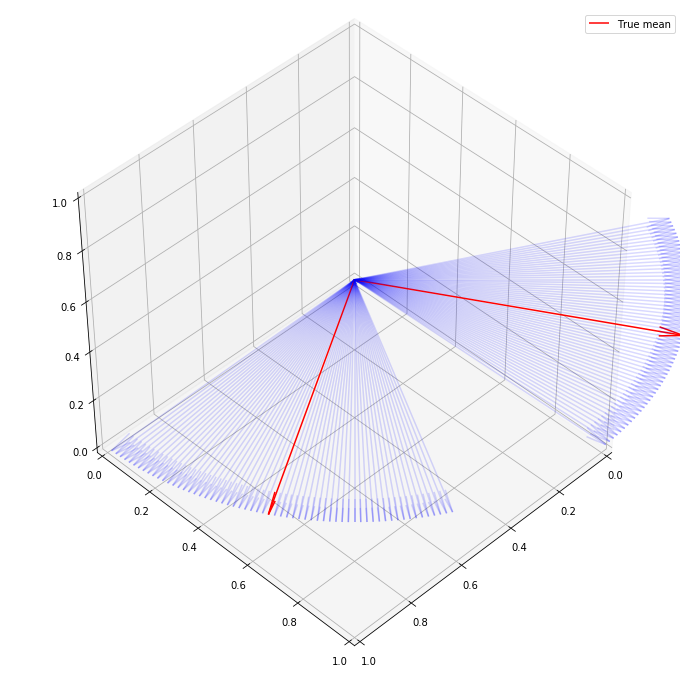

In [5]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

origin = [0,0,0]

for i, frame_rot in enumerate(Frame_rot):
    X, Y, Z = zip(origin, origin) 
    U, V, W = zip(frame_rot.T[0], frame_rot.T[1])
    c = "blue"
    alpha = 0.15
    label = None
    if i == sought_for_mean_idx:
        c = "red"
        alpha = 1
        label = "True mean"
    ax.quiver(X,Y,Z,U,V,W, color=c, alpha=alpha, arrow_length_ratio=0.075, label=label)

ax.set_xlim([0,1.0])
ax.set_ylim([0,1.0])
ax.set_zlim([0,1.0])
ax.view_init(45, 45)
ax.legend()

plt.show()

## Mean, exponential and logarithmic maps

In [7]:
def mean(X, Qs):
    
    # lift points to tangent space
    V = []
    for i, Q in enumerate(Qs):
        try:
            v = log(X, Q)
            V.append(v)
        except Exception as error:
            pass
            print("Q does not belong to the domain of the lifting map P_X^{-1}, because of", error)
            
    if len(V) <=0:
        raise Exception("V is empty")
            
    V = np.array(V)
    
    # average in tangent space
    V = np.mean(V, axis=0)
    
    # retract computed mean to manifold
    X_mean = exp(X, V)

    return X_mean

def exp(X, V):
    
    n, p = X.shape
    
    A = np.matmul(X.T, V)
    K = V - np.matmul(X, A)
    Q, R = qr(K)
    
    MNe = expm(np.block([[A, -R.T], [R, np.zeros((p,p))]]))
    
    return np.matmul(np.block([X, Q]), MNe[:, 0:p])

def log(X0, X1, max_iter=100, tol=1e-6):
    
    n, p = X0.shape
    
    conv_hist = []
    
    M = np.matmul(X0.T, X1)
    
    # QR of normal component of X1
    Q, N = qr(X1 - np.matmul(X0, M))
    
    # orthogonal completion
    V, _ = qr(np.block([[M], [N]]), mode="complete")
    
    # Procrustes preprocessing
    D, S, R = np.linalg.svd(V[p:2*p, p:2*p])
    V[:, p:2*p] = np.matmul(V[:, p:2*p], np.matmul(R, D.T))
    V = np.block([np.block([[M], [N]]), V[:, p:2*p]])
    
    norm_logV0 = np.linalg.norm(logm(V), 2)
    
    for k in range(max_iter):
        LV = logm(V)
        
        C = LV[p:2*p, p:2*p]
        normC = np.linalg.norm(C, 2)
        conv_hist.append(normC)
        
        if normC < tol:
            #print("Converged in {} iterations".format(k+1))
            break
            
        Phi = expm(-C)
        V[:, p:2*p] = np.matmul(V[:, p:2*p], Phi)
        
    return np.matmul(X0, LV[0:p, 0:p]) + np.matmul(Q, LV[p:2*p, 0:p])

## Compute mean

Set $X_{mean}$ as initial sought-for-mean frame, taken in random from given frames.  
Run fixed-point algorithm until convergence

In [17]:
tries = 10

for k in range(tries):
    
    random_id = random.randrange(N)
    X_mean = Frame_rot[random_id]
    Q = Frame_rot
    
    i = 0
    tol = 1e-8
    converged = False

    while not converged:
        i += 1
        X_mean_prev = np.copy(X_mean)

        X_mean = mean(X_mean, Q)

        if np.linalg.norm(X_mean - X_mean_prev) <= tol:
            converged = True
            print("Converged in {} iterations".format(i))

X_mean

Converged in 2 iterations
Converged in 2 iterations
Converged in 2 iterations
Converged in 2 iterations
Converged in 2 iterations
Converged in 2 iterations
Converged in 2 iterations
Converged in 2 iterations
Converged in 2 iterations
Converged in 2 iterations


array([[ 0.8571673 , -0.51503807],
       [ 0.51503807,  0.8571673 ],
       [ 0.        ,  0.        ]])

True mean

In [18]:
Frame_rot[sought_for_mean_idx]

array([[ 0.8571673 , -0.51503807],
       [ 0.51503807,  0.8571673 ],
       [ 0.        ,  0.        ]])

Norm of the difference of computed mean with true mean

In [19]:
np.linalg.norm(X_mean - Frame_rot[sought_for_mean_idx])

5.768888059150692e-16

## Plot computed mean

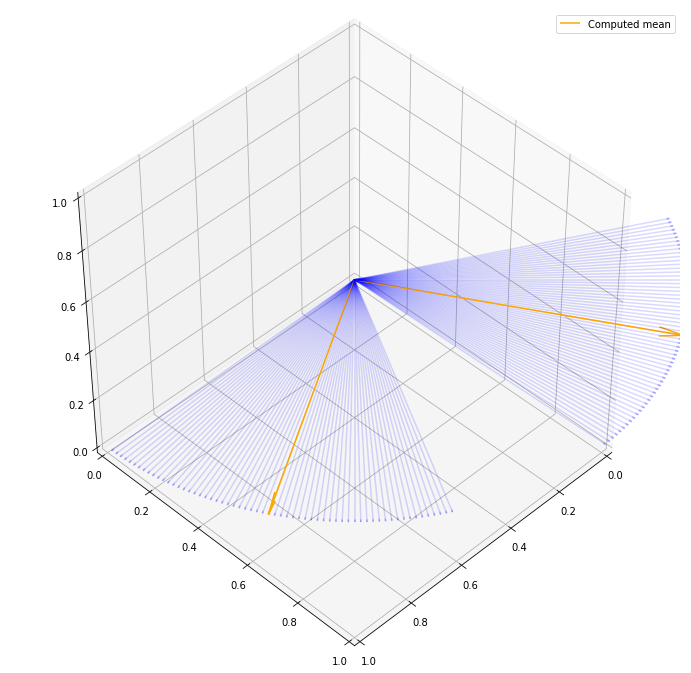

In [20]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

origin = [0,0,0]

for i, frame_rot in enumerate(Frame_rot):
    X, Y, Z = zip(origin, origin) 
    U, V, W = zip(frame_rot.T[0], frame_rot.T[1])
    c = "blue"
    alpha = 0.15
    ax.quiver(X,Y,Z,U,V,W, color=c, alpha=alpha, arrow_length_ratio=0.01)

X, Y, Z = zip(origin, origin) 
U, V, W = zip(X_mean.T[0], X_mean.T[1])
ax.quiver(X,Y,Z,U,V,W, color="orange", alpha=1, arrow_length_ratio=0.075, label='Computed mean')

ax.set_xlim([0,1.0])
ax.set_ylim([0,1.0])
ax.set_zlim([0,1.0])
ax.view_init(45, 45)
ax.legend()

plt.show()